# 0. Importamos librerías

In [1]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# 1. Análisis Exploratorio de Datos

## 1.1. Datos generales del dataset

Cargamos el dataset y mostramos las primeras 10 muestras del mismo. También el nombre de las columnas.

In [2]:
df = pd.read_csv("thyroid0387.csv")
df.head(10)

,age,sex,ot,qot,oam,sick,pregnant,thyroid surgery,I131,qhypo,...,TT4?,TT4,T4U?,T4U,FTI?,FTI,TBG?,TBG,source,class
0,29,F,f,f,f,f,f,f,f,t,...,f,?,f,?,f,?,f,?,other,-[840801013]
1,29,F,f,f,f,f,f,f,f,f,...,t,128,f,?,f,?,f,?,other,-[840801014]
2,41,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,11,other,-[840801042]
3,36,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803046]
4,32,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,36,other,S[840803047]
5,60,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803048]
6,77,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,21,other,-[840803068]
7,28,F,f,f,f,f,f,f,f,f,...,t,116,f,?,f,?,f,?,SVI,-[840807019]
8,28,F,f,f,f,f,f,f,f,f,...,t,76,f,?,f,?,f,?,other,-[840808060]
9,28,F,f,f,f,f,f,f,f,f,...,t,83,f,?,f,?,f,?,other,-[840808073]


In [3]:
df.columns

Index(['age', 'sex', 'ot', 'qot', 'oam', 'sick', 'pregnant', 'thyroid surgery',
       'I131', 'qhypo', 'qhyper', 'lithium', 'goitre', 'tumor', 'hypo',
       'psych', 'TSH?', 'TSH', 'T3?', 'T3', 'TT4?', 'TT4', 'T4U?', 'T4U',
       'FTI?', 'FTI', 'TBG?', 'TBG', 'source', 'class'],
      dtype='object')

Vemos que la mayoría de variables son booleanas y el sexo es Masculino o Femenino. Esto lo podemos corroborar con el archivo `.names`.

Attribute Name			        Possible Values
- age:				            continuous.
- sex:				            M, F.
- on thyroxine:			        f, t.
- query on thyroxine:		    f, t.
- on antithyroid medication:	f, t.
- sick:				            f, t.
- pregnant:			            f, t.
- thyroid surgery:		        f, t.
- I131 treatment:			    f, t.
- query hypothyroid:		    f, t.
- query hyperthyroid:		    f, t.
- lithium:			            f, t.
- goitre:				        f, t.
- tumor:				        f, t.
- hypopituitary:			    f, t.
- psych:				        f, t.
- TSH measured:			        f, t.
- TSH:				            continuous.
- T3 measured:			        f, t.
- T3:				            continuous.
- TT4 measured:			        f, t.
- TT4:				            continuous.
- T4U measured:			        f, t.
- T4U:				            continuous.
- FTI measured:			        f, t.
- FTI:				            continuous.
- TBG measured:			        f, t.
- TBG:				            continuous.
- referral source:		        WEST, STMW, SVHC, SVI, SVHD, other.

Veamos ahora la información del dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              9172 non-null   int64 
 1   sex              9172 non-null   object
 2   ot               9172 non-null   object
 3   qot              9172 non-null   object
 4   oam              9172 non-null   object
 5   sick             9172 non-null   object
 6   pregnant         9172 non-null   object
 7   thyroid surgery  9172 non-null   object
 8   I131             9172 non-null   object
 9   qhypo            9172 non-null   object
 10  qhyper           9172 non-null   object
 11  lithium          9172 non-null   object
 12  goitre           9172 non-null   object
 13  tumor            9172 non-null   object
 14  hypo             9172 non-null   object
 15  psych            9172 non-null   object
 16  TSH?             9172 non-null   object
 17  TSH              9172 non-null   

Hay 9172 muestras y un total de 30 columnas, donde hay solo una variable numérica el cual es la edad, mientras que el resto de variables son objetos. Veamos los valores que contienen algunas de las variables de tipo objeto.

In [5]:
df["sex"].unique()

array(['F', 'M', '?'], dtype=object)

In [6]:
df["TSH"].unique()

array(['0.3', '1.6', '?', '0.7', '1.2', '1.9', '1', '0.5', '2.6', '68',
       '1.5', '5.9', '0.05', '4', '0.4', '0.8', '0.2', '3', '9.599999',
       '140', '0.6', '1.7', '2.5', '6.8', '2.1', '1.1', '9.799999', '3.7',
       '0.1', '0.35', '90', '1.3', '2.7', '2.9', '0.25', '5.8', '2',
       '0.9', '3.2', '7.4', '1.8', '5', '70', '6.5', '11.599999', '4.2',
       '88', '2.2', '53', '16.5', '8.4', '4.1', '3.3', '80', '176', '30',
       '11', '6', '71', '9.099999', '10.7', '4.9', '3.4', '1.83', '4.6',
       '1.4', '14', '3.5', '46', '18', '170', '19.199999', '7.5', '145',
       '7.9', '19', '48', '25', '7.3', '6.7', '153', '35', '3.8', '2.3',
       '9.2', '12', '5.5', '15.299999', '0.15', '10.299999', '430', '213',
       '37', '216', '26', '4.3', '2.4', '47', '8.2', '14.4', '17.4',
       '100', '13.2', '41', '3.1', '22', '45', '4.5', '24', '65', '4.4',
       '56', '11.4', '5.2', '5.6', '8.299999', '400', '260', '5.4', '8',
       '6.6', '8.5', '5.1', '138', '42', '44', '2.8', '1

Algunas de las variables tipo objeto son numéricas pero en forma de strings. Esto se arreglará en el pre-procesamiento de datos. Por otro lado, algunos de los valores faltantes en lugar de ser NaN son signos de interrogación, estos también serán modificados en el pre-procesamiento.

# 2. Pre-procesamiento de datos

## 2.1. Reemplazamos variables faltantes por NaN

Utilizamos el método `replace` para reemplazar los signos de interrogación por NaN.

<Axes: >

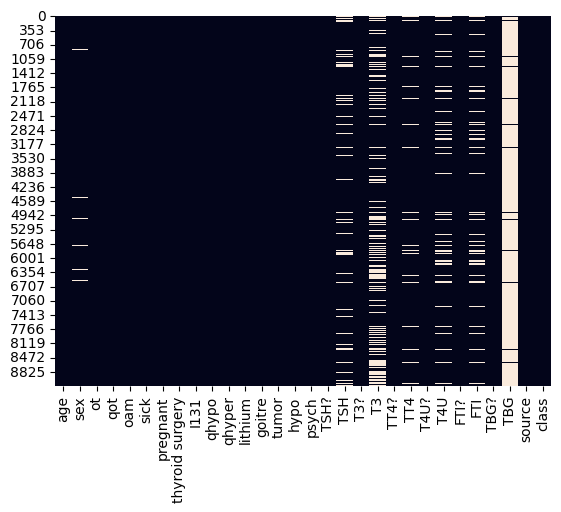

In [7]:
df = df.replace("?", np.nan)
sns.heatmap(df.isnull(), cbar=False)

## 2.2. Variables de tipo objeto a variables de tipo entero

Reemplazamos las variables de sexo y las variables de verdadero y falso a variables de tipo entero para un manejo más sencillo de los mismos.

In [8]:
df = df.replace(["M", "f", "F", "t"], [0, 0, 1, 1])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              9172 non-null   int64  
 1   sex              8865 non-null   float64
 2   ot               9172 non-null   int64  
 3   qot              9172 non-null   int64  
 4   oam              9172 non-null   int64  
 5   sick             9172 non-null   int64  
 6   pregnant         9172 non-null   int64  
 7   thyroid surgery  9172 non-null   int64  
 8   I131             9172 non-null   int64  
 9   qhypo            9172 non-null   int64  
 10  qhyper           9172 non-null   int64  
 11  lithium          9172 non-null   int64  
 12  goitre           9172 non-null   int64  
 13  tumor            9172 non-null   int64  
 14  hypo             9172 non-null   int64  
 15  psych            9172 non-null   int64  
 16  TSH?             9172 non-null   int64  
 17  TSH           

## 2.3. Variables de tipo objeto a variables de tipo float

Reemplazamos todas las variables de tipo objeto restantes por variables de tipo float, excepto por source y class pues estos no son numéricos.

In [9]:
cols = df.columns.difference(["source", "class"])
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              9172 non-null   int64  
 1   sex              8865 non-null   float64
 2   ot               9172 non-null   int64  
 3   qot              9172 non-null   int64  
 4   oam              9172 non-null   int64  
 5   sick             9172 non-null   int64  
 6   pregnant         9172 non-null   int64  
 7   thyroid surgery  9172 non-null   int64  
 8   I131             9172 non-null   int64  
 9   qhypo            9172 non-null   int64  
 10  qhyper           9172 non-null   int64  
 11  lithium          9172 non-null   int64  
 12  goitre           9172 non-null   int64  
 13  tumor            9172 non-null   int64  
 14  hypo             9172 non-null   int64  
 15  psych            9172 non-null   int64  
 16  TSH?             9172 non-null   int64  
 17  TSH           

## 2.4. Limpieza de datos

Notemos que la variable TBG contiene una cantidad excesiva de valores faltantes, por ello, este será eliminado junto con la variable TBG? (pues están relacionadas) del dataset ya que imputar datos puede ser muy invasivo para la integridad del dataset.

<Axes: >

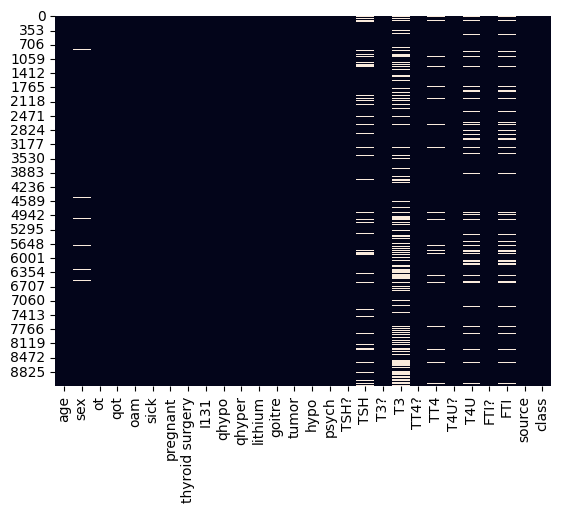

In [10]:
df = df.drop(["TBG?", "TBG"], axis=1)
sns.heatmap(df.isnull(), cbar=False)

Eliminamos las muestras que no contengan valores conocidos de sexo, ya que no son una cantidad significativa dentro del dataset.

<Axes: >

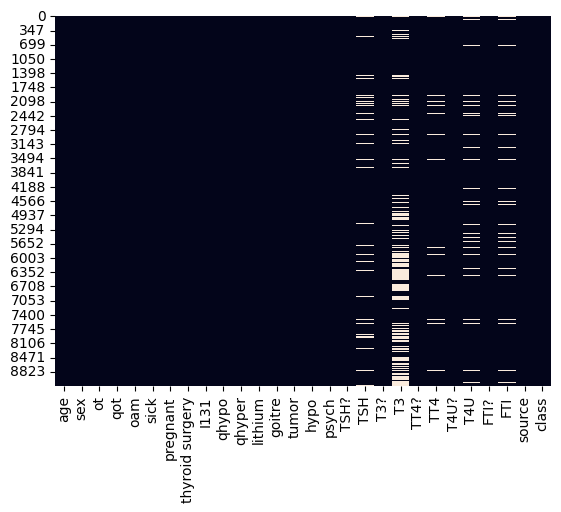

In [11]:
df = df.dropna(axis=0, subset="sex")
sns.heatmap(df.isnull(), cbar=False)

## 2.5. Imputación de variables numéricas

Si bien las variables TSH, T3, TT4, T4U y FTI contienen una gran cantidad de valores desconocidos, estas son variables importantes para determinar el tipo de enfermedad de tiroides del paciente. Es por ello que en lugar de eliminar las variables, se imputarán los valores faltantes con la media de la variable, esto puede afectar a la calidad de la información del dataset, sin embargo es importante considerar que no se suele tomar datos de los pacientes que están sanos, y son estos pacientes los que tienen un valor promedio en cada una de las variables, por lo que asumir que las variables faltantes es la media de los valores encontrados no es descabellado.

In [12]:
df["TSH"].fillna(df["TSH"].mean(skipna=True), inplace=True)
df["T3"].fillna(df["T3"].mean(skipna=True), inplace=True)
df["TT4"].fillna(df["TT4"].mean(skipna=True), inplace=True)
df["T4U"].fillna(df["T4U"].mean(skipna=True), inplace=True)
df["FTI"].fillna(df["FTI"].mean(skipna=True), inplace=True)

<Axes: >

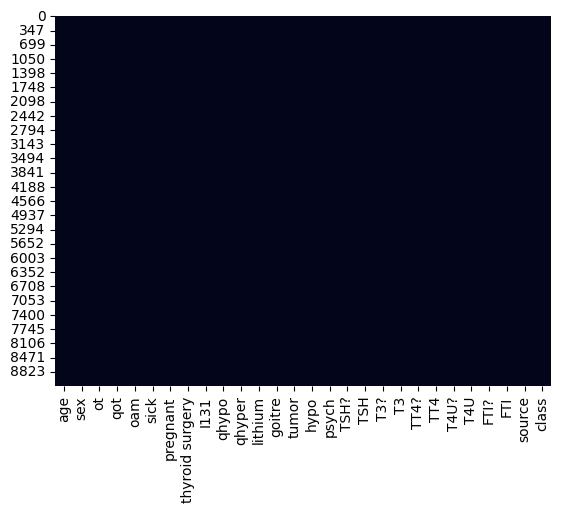

In [13]:
sns.heatmap(df.isnull(), cbar=False)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8865 entries, 0 to 9171
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8865 non-null   int64  
 1   sex              8865 non-null   float64
 2   ot               8865 non-null   int64  
 3   qot              8865 non-null   int64  
 4   oam              8865 non-null   int64  
 5   sick             8865 non-null   int64  
 6   pregnant         8865 non-null   int64  
 7   thyroid surgery  8865 non-null   int64  
 8   I131             8865 non-null   int64  
 9   qhypo            8865 non-null   int64  
 10  qhyper           8865 non-null   int64  
 11  lithium          8865 non-null   int64  
 12  goitre           8865 non-null   int64  
 13  tumor            8865 non-null   int64  
 14  hypo             8865 non-null   int64  
 15  psych            8865 non-null   int64  
 16  TSH?             8865 non-null   int64  
 17  TSH           

## 2.6. Separación en clases y etiquetas

Separamos el dataset en un set de variables de características llamado `X` y un set de etiquetas llamano `y`.

In [15]:
X = df.drop(["source", "class"], axis=1)
y = df[["class"]]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8865 entries, 0 to 9171
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8865 non-null   int64  
 1   sex              8865 non-null   float64
 2   ot               8865 non-null   int64  
 3   qot              8865 non-null   int64  
 4   oam              8865 non-null   int64  
 5   sick             8865 non-null   int64  
 6   pregnant         8865 non-null   int64  
 7   thyroid surgery  8865 non-null   int64  
 8   I131             8865 non-null   int64  
 9   qhypo            8865 non-null   int64  
 10  qhyper           8865 non-null   int64  
 11  lithium          8865 non-null   int64  
 12  goitre           8865 non-null   int64  
 13  tumor            8865 non-null   int64  
 14  hypo             8865 non-null   int64  
 15  psych            8865 non-null   int64  
 16  TSH?             8865 non-null   int64  
 17  TSH           

## 2.7. Procesamiento de etiquetas

Verifiquemos el número de valores únicos que tiene la variable `"class"`.

In [16]:
print(len(y["class"].unique()))

8865


In [17]:
print(y)

             class
0     -[840801013]
1     -[840801014]
2     -[840801042]
3     -[840803046]
4     S[840803047]
...            ...
9167  -[870119022]
9168  -[870119023]
9169  I[870119025]
9170  -[870119027]
9171  -[870119035]

[8865 rows x 1 columns]


Al parecer cada una de las muestras tiene diferentes valores, por lo que utilizaremos Regex para extraer los caracteres previos a los corchetes. Esto se corrobora con lo que se indica en el archivo `.names`.

Letter	Diagnosis

hyperthyroid conditions:

    A	hyperthyroid
    B	T3 toxic
    C	toxic goitre
    D	secondary toxic

hypothyroid conditions:

    E	hypothyroid
    F	primary hypothyroid
    G	compensated hypothyroid
    H	secondary hypothyroid

binding protein:

    I	increased binding protein
    J	decreased binding protein

general health:

    K	concurrent non-thyroidal illness

replacement therapy:

    L	consistent with replacement therapy
    M	underreplaced
    N	overreplaced

antithyroid treatment:

    O	antithyroid drugs
    P	I131 treatment
    Q	surgery

miscellaneous:

    R	discordant assay results
    S	elevated TBG
		T	elevated thyroid hormones

In [18]:
pattern = r"^(.*?)\["
y["class"] = y["class"].str.extract(pattern)
print(y)

     class
0        -
1        -
2        -
3        -
4        S
...    ...
9167     -
9168     -
9169     I
9170     -
9171     -

[8865 rows x 1 columns]


C:\Users\eavil\AppData\Local\Temp\ipykernel_28900\1086453790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["class"] = y["class"].str.extract(pattern)


Ahora que se extrajeron los caracteres, verificamos los nuevos valores únicos.

In [19]:
print(y["class"].unique())

['-' 'S' 'F' 'AK' 'R' 'I' 'M' 'N' 'G' 'K' 'A' 'L' 'MK' 'Q' 'J' 'C|I' 'O'
 'LJ' 'H|K' 'GK' 'MI' 'KJ' 'P' 'FK' 'B' 'GI' 'C' 'GKJ' 'OI' 'D|R' 'D' 'E']


Hay una cantidad de clases relativamente grande, por lo que vemos la distribución de estas en el dataset.

<Axes: xlabel='class', ylabel='count'>

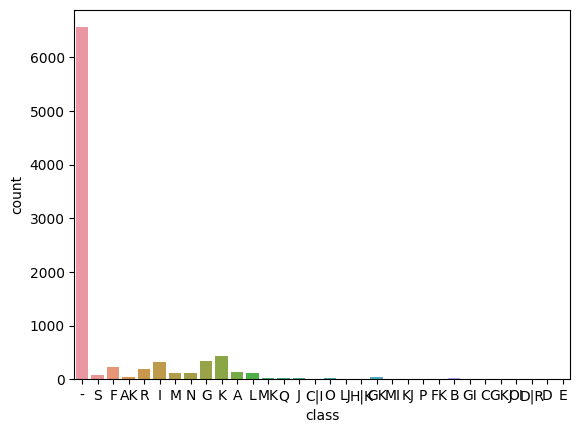

In [20]:
sns.countplot(x="class", data=y)

Está claro que la mayoría de clases no tiene una cantidad suficiente de muestras para la predicción, por ello nos quedamos con las clases que contengan al menos 100 muestras.

<Axes: xlabel='class', ylabel='count'>

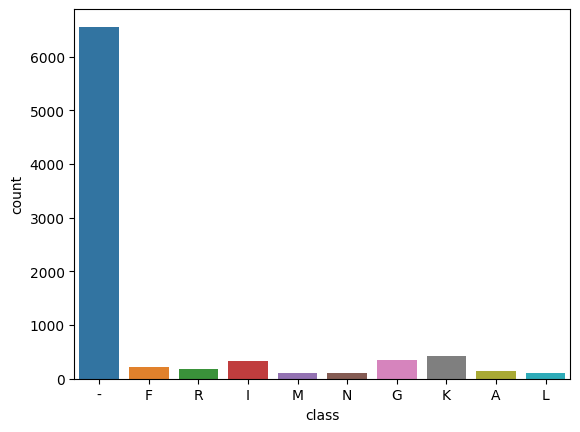

In [21]:
counts = y["class"].value_counts()
new_values = counts[counts >= 100].index.to_list()
mask1 = y["class"].isin(new_values)
y = y[mask1]
sns.countplot(x="class", data=y)

Aplicamos la misma máscara para la matriz de variables de manera que se mantiene el número de dimensiones.

In [22]:
X = X[mask1]
X.shape

(8536, 26)

Le asignamos a cada clase un número para que XGBClassifier pueda entrenar estos datos.

In [23]:
string_counts = y["class"].value_counts()
string_ranks = string_counts.rank(method="min", ascending=False)
y["class"] = y["class"].map(string_ranks)
y = y-1
y

,class
0,0.0
1,0.0
2,0.0
3,0.0
5,0.0
...,...
9167,0.0
9168,0.0
9169,3.0
9170,0.0


# 3. Visualización de datos

Veamos la descripción del dataset de características.

In [24]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8536.0,75.302484,1227.268050,1.000,37.00,55.000000,68.00,65526.00
sex,8536.0,0.679241,0.466796,0.000,0.00,1.000000,1.00,1.00
ot,8536.0,0.138707,0.345660,0.000,0.00,0.000000,0.00,1.00
qot,8536.0,0.017573,0.131400,0.000,0.00,0.000000,0.00,1.00
oam,8536.0,0.011481,0.106538,0.000,0.00,0.000000,0.00,1.00
sick,8536.0,0.037488,0.189966,0.000,0.00,0.000000,0.00,1.00
pregnant,8536.0,0.011012,0.104366,0.000,0.00,0.000000,0.00,1.00
thyroid surgery,8536.0,0.013355,0.114797,0.000,0.00,0.000000,0.00,1.00
I131,8536.0,0.018158,0.133532,0.000,0.00,0.000000,0.00,1.00
qhypo,8536.0,0.068533,0.252674,0.000,0.00,0.000000,0.00,1.00


In [25]:
print(X["age"].unique())

[   29    41    36    60    77    28    54    42    51    37    16    43
    63    40    56    85    71    67    55    32    61    46    44    82
    64    70    33    59    53    52    49    35    48    27    69    76
    73    68    66    30    88    38    58    21    45    83    62    25
    86    75    72    14    15    39    26    20    80    90    23    18
    13    78    24    81    92    57    74     9    47    17    11    50
    34     8    79    31    65    84    12    10    22     1    97     6
    19    89    87   455    93     7     2    91     5    94     4 65511
    95 65512     3 65526]


Notemos que hay valores de edad que no tienen sentido, por lo que las eliminamos tanto del set de características como del set de etiquetas.

In [26]:
mask2 = (X["age"] != 65511) & (X["age"] != 65512) & (X["age"] != 65526) & (X["age"] != 455)
X = X[mask2]
y = y[mask2]
X.shape, y.shape

((8532, 26), (8532, 1))

In [27]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8532.0,52.247773,18.877534,1.000,37.00,55.000000,68.00,97.00
sex,8532.0,0.679325,0.466763,0.000,0.00,1.000000,1.00,1.00
ot,8532.0,0.138772,0.345728,0.000,0.00,0.000000,0.00,1.00
qot,8532.0,0.017581,0.131430,0.000,0.00,0.000000,0.00,1.00
oam,8532.0,0.011486,0.106563,0.000,0.00,0.000000,0.00,1.00
sick,8532.0,0.037506,0.190009,0.000,0.00,0.000000,0.00,1.00
pregnant,8532.0,0.011017,0.104390,0.000,0.00,0.000000,0.00,1.00
thyroid surgery,8532.0,0.013361,0.114824,0.000,0.00,0.000000,0.00,1.00
I131,8532.0,0.018167,0.133563,0.000,0.00,0.000000,0.00,1.00
qhypo,8532.0,0.068565,0.252728,0.000,0.00,0.000000,0.00,1.00


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8532 entries, 0 to 9171
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8532 non-null   int64  
 1   sex              8532 non-null   float64
 2   ot               8532 non-null   int64  
 3   qot              8532 non-null   int64  
 4   oam              8532 non-null   int64  
 5   sick             8532 non-null   int64  
 6   pregnant         8532 non-null   int64  
 7   thyroid surgery  8532 non-null   int64  
 8   I131             8532 non-null   int64  
 9   qhypo            8532 non-null   int64  
 10  qhyper           8532 non-null   int64  
 11  lithium          8532 non-null   int64  
 12  goitre           8532 non-null   int64  
 13  tumor            8532 non-null   int64  
 14  hypo             8532 non-null   int64  
 15  psych            8532 non-null   int64  
 16  TSH?             8532 non-null   int64  
 17  TSH           

## 3.1. Distribución de variables categóricas

Ahora veamos la distribución de las variables categóricas tanto para las variables que contienen verdadero o falso como para la variable de sexo.

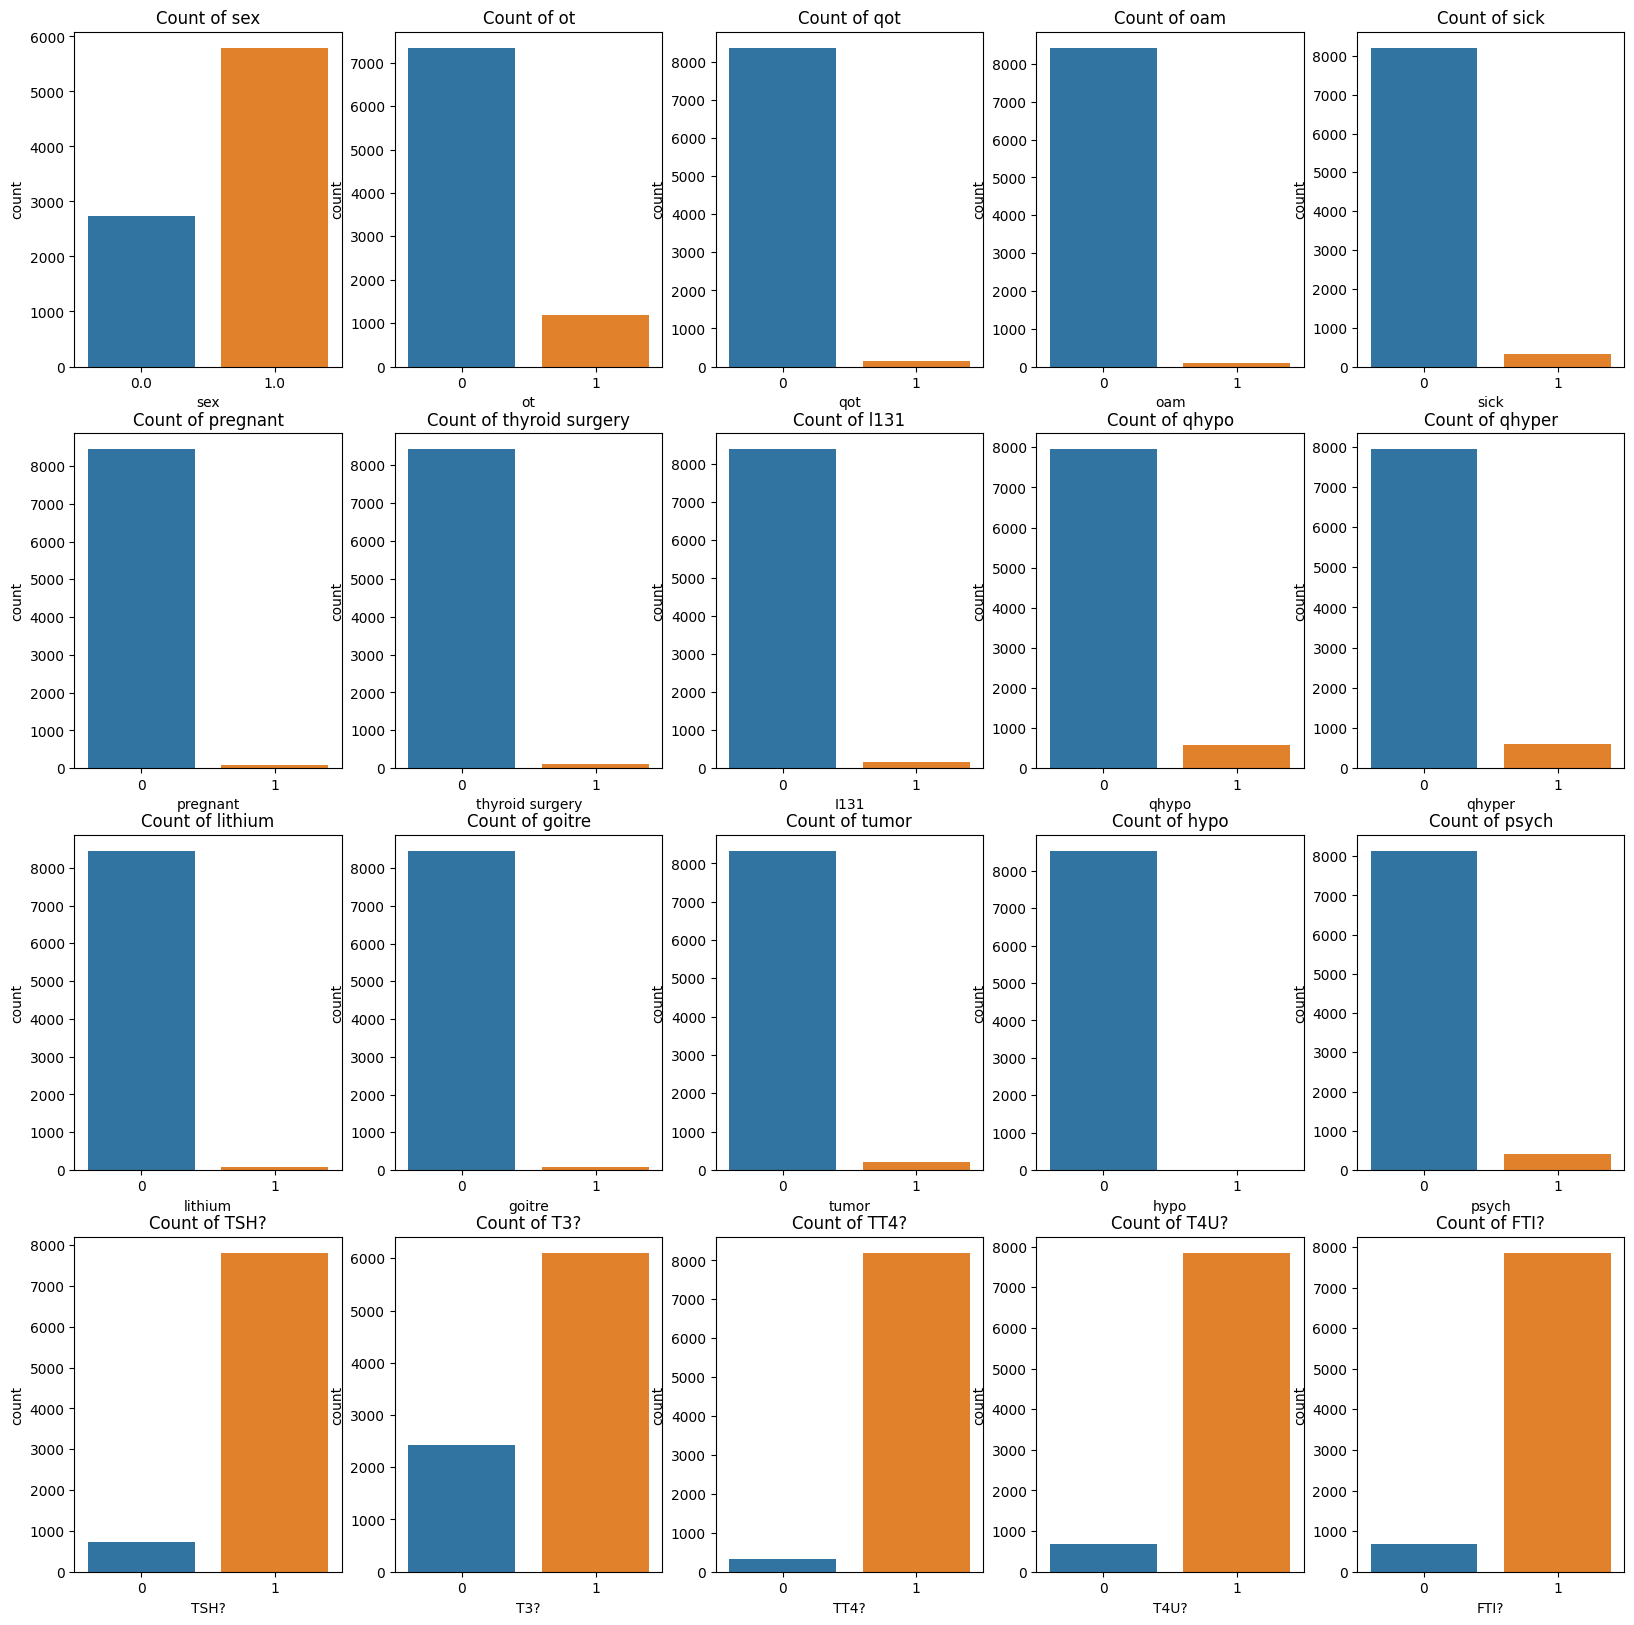

In [29]:
fig, ax = plt.subplots(4, 5, figsize=(20, 20))
sns.countplot(x="sex", data=X, ax=ax[0, 0])
sns.countplot(x="ot", data=X, ax=ax[0, 1])
sns.countplot(x="qot", data=X, ax=ax[0, 2])
sns.countplot(x="oam", data=X, ax=ax[0, 3])
sns.countplot(x="sick", data=X, ax=ax[0, 4])
sns.countplot(x="pregnant", data=X, ax=ax[1, 0])
sns.countplot(x="thyroid surgery", data=X, ax=ax[1, 1])
sns.countplot(x="I131", data=X, ax=ax[1, 2])
sns.countplot(x="qhypo", data=X, ax=ax[1, 3])
sns.countplot(x="qhyper", data=X, ax=ax[1, 4])
sns.countplot(x="lithium", data=X, ax=ax[2, 0])
sns.countplot(x="goitre", data=X, ax=ax[2, 1])
sns.countplot(x="tumor", data=X, ax=ax[2, 2])
sns.countplot(x="hypo", data=X, ax=ax[2, 3])
sns.countplot(x="psych", data=X, ax=ax[2, 4])
sns.countplot(x="TSH?", data=X, ax=ax[3, 0])
sns.countplot(x="T3?", data=X, ax=ax[3, 1])
sns.countplot(x="TT4?", data=X, ax=ax[3, 2])
sns.countplot(x="T4U?", data=X, ax=ax[3, 3])
sns.countplot(x="FTI?", data=X, ax=ax[3, 4])
ax[0, 0].set_title("Count of sex")
ax[0, 1].set_title("Count of ot")
ax[0, 2].set_title("Count of qot")
ax[0, 3].set_title("Count of oam")
ax[0, 4].set_title("Count of sick")
ax[1, 0].set_title("Count of pregnant")
ax[1, 1].set_title("Count of thyroid surgery")
ax[1, 2].set_title("Count of l131")
ax[1, 3].set_title("Count of qhypo")
ax[1, 4].set_title("Count of qhyper")
ax[2, 0].set_title("Count of lithium")
ax[2, 1].set_title("Count of goitre")
ax[2, 2].set_title("Count of tumor")
ax[2, 3].set_title("Count of hypo")
ax[2, 4].set_title("Count of psych")
ax[3, 0].set_title("Count of TSH?")
ax[3, 1].set_title("Count of T3?")
ax[3, 2].set_title("Count of TT4?")
ax[3, 3].set_title("Count of T4U?")
ax[3, 4].set_title("Count of FTI?")
plt.show()

## 3.2. Distribución de variables numéricas

Ahora veamos la distribución de las variables numéricas usando histogramas.

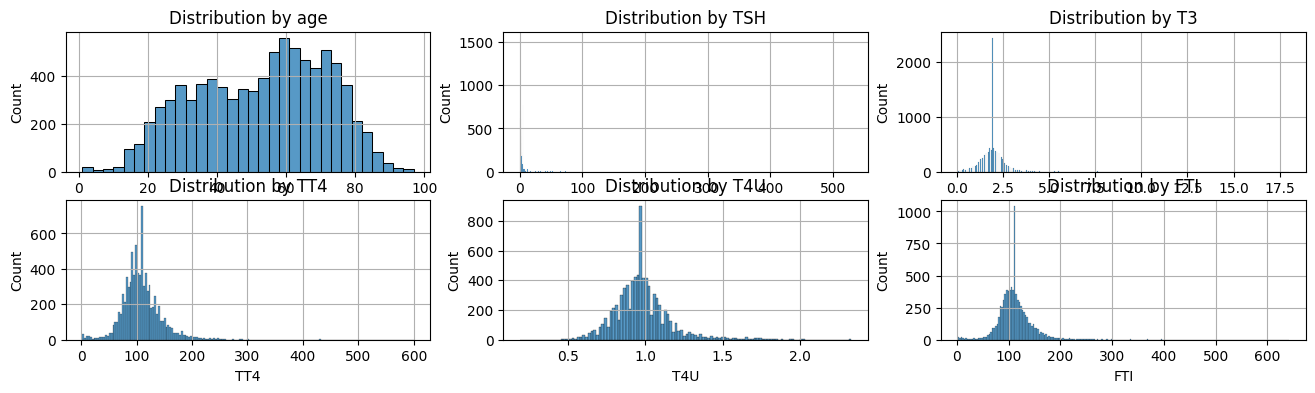

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(16, 4))
sns.histplot(x="age", data=X, ax=ax[0, 0])
sns.histplot(x="TSH", data=X, ax=ax[0, 1])
sns.histplot(x="T3", data=X, ax=ax[0, 2])
sns.histplot(x="TT4", data=X, ax=ax[1, 0])
sns.histplot(x="T4U", data=X, ax=ax[1, 1])
sns.histplot(x="FTI", data=X, ax=ax[1, 2])
ax[0, 0].set_title("Distribution by age")
ax[0, 0].grid(True)
ax[0, 1].set_title("Distribution by TSH")
ax[0, 1].grid(True)
ax[0, 2].set_title("Distribution by T3")
ax[0, 2].grid(True)
ax[1, 0].set_title("Distribution by TT4")
ax[1, 0].grid(True)
ax[1, 1].set_title("Distribution by T4U")
ax[1, 1].grid(True)
ax[1, 2].set_title("Distribution by FTI")
ax[1, 2].grid(True)
plt.show()

Notamos que la mayoría de las variables sigue una distribución normal, mientras que TSH tiene una distribución con outliers, estos no serán eliminados pues un valor muy alto de TSH es un indicador de hipotiroidismo.

## 3.3. Set de entrenamiento y testeo

Separamos el dataset en un set de entrenamiento y de testeo.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6399, 26), (2133, 26), (6399, 1), (2133, 1))

# 4. Modelo

## 4.1. Selección del modelo

Para elegir el modelo con el que se realizará la optimización de hiperparámetros, se usará un Pipeline que contenga diferentes clasificadores vistos en clase.

In [32]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

In [33]:
params = dict(
    clf = [
        LogisticRegression(random_state=42),
        KNeighborsClassifier(),
        GaussianNB(),
        SVC(random_state=42),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42)
    ],   
)

In [34]:
grid_search = GridSearchCV(pipe, params, n_jobs=-1)

In [35]:
grid_search.fit(X_train, y_train)

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf': [LogisticRegression(random_state=42),
                                 KNeighborsClassifier(), GaussianNB(),
                                 SVC(random_state=42),
                                 DecisionTreeClassifier(random_state=42),
                                 RandomForestClassifier(random_state=42)]})

In [36]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))])

In [37]:
grid_search.best_score_

0.9578057808835027

Como era de esperarse, al tener una gran cantidad de características, el método de ensamble es capaz de encontrar relaciones entre características de forma más eficiente. Es así que se realizará una optimización de hiperparámetros para RandomForest, y posterior a esto se comparará los resultados del modelo RandomForest optimizado con los predeterminados de otros modelos de ensamble como XGBoost, LightGBM y CatBoost. Estos últimos no se optimizará pues requieren de mucho tiempo de ejecución.

## 4.2. Optimización de hiperparámetros

In [38]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [39]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

Por la gran cantidad de hiperparámetros con las que cuenta este tipo de clasificador, se realizará la optimización para ciertos parámetros tales como `depth`, `learning_rate` e `iterations`.

In [40]:
param_grid = dict(
    classifier__n_estimators=[i for i in range(50, 500)],
    classifier__criterion=["gini", "entropy", "log_loss"],
    classifier__max_features=["sqrt", "log2"]
)

In [41]:
best_model1 = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=8, n_iter=200, n_jobs=-1, random_state=42)
best_model1.fit(X_train, y_train)

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy',
                                                                  'log_loss'],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__n_estimators': [50, 51, 52,
                                                                     53, 54, 55,
                                                                     56, 57, 58,
                                                                     59, 60, 61,
                                                                     62, 63, 64,
                                                                     65, 66, 67,
                                                                     68, 69, 70,
                                                                     71, 72, 73,
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...]},
                   random_state=42)

In [42]:
best_model1.best_score_

0.9610890566332916

In [43]:
print(accuracy_score(y_test, best_model1.predict(X_test)))

0.9479606188466948


## 4.3. Comparación con otros modelos de ensamble

In [44]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

In [45]:
params = dict(
    clf = [
        XGBClassifier(),
        LGBMClassifier(random_state=42),
        CatBoostClassifier(random_state=42)
    ],   
)

In [46]:
grid_search = GridSearchCV(pipe, params, n_jobs=-1)

In [47]:
grid_search.fit(X_train, y_train)

Learning rate set to 0.086983
0:	learn: 1.7465700	total: 149ms	remaining: 2m 28s
1:	learn: 1.4718349	total: 161ms	remaining: 1m 20s
2:	learn: 1.2793666	total: 173ms	remaining: 57.3s
3:	learn: 1.1347726	total: 184ms	remaining: 45.9s
4:	learn: 1.0268736	total: 194ms	remaining: 38.6s
5:	learn: 0.9404406	total: 205ms	remaining: 33.9s
6:	learn: 0.8688758	total: 217ms	remaining: 30.7s
7:	learn: 0.7997451	total: 228ms	remaining: 28.2s
8:	learn: 0.7335698	total: 238ms	remaining: 26.3s
9:	learn: 0.6789056	total: 249ms	remaining: 24.6s
10:	learn: 0.6356702	total: 259ms	remaining: 23.3s
11:	learn: 0.5920987	total: 270ms	remaining: 22.3s
12:	learn: 0.5580761	total: 282ms	remaining: 21.4s
13:	learn: 0.5277685	total: 296ms	remaining: 20.8s
14:	learn: 0.4989916	total: 307ms	remaining: 20.2s
15:	learn: 0.4728738	total: 318ms	remaining: 19.6s
16:	learn: 0.4481091	total: 329ms	remaining: 19s
17:	learn: 0.4259509	total: 342ms	remaining: 18.6s
18:	learn: 0.4051620	total: 351ms	remaining: 18.1s
19:	learn: 

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf': [XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_ty...
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None,
                                               random_state=None, ...),
                                 LGBMClassifier(random_state=42),
                                 <catboost.core.CatBoostClassifier object at 0x000001F40370CB80>]})

In [48]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x000001F4022E5220>)])

In [49]:
grid_search.best_score_

0.9601503860437843

In [50]:
accuracy_score(y_test, grid_search.predict(X_test))

0.9423347398030942

Comparando la precisión para el set de entrenamiento y testeo, el modelo RandomForest optimizado es el mejor modelo.

## 4.3. Iteración con data balanceada

Previamente se observó que la data contenía muchas muestras que no tenían observaciones en cuanto a su estado de salud. Es por esto que se realizará un balanceo de data, y para ello se optimizará otro modelo RandomForest. Más adelante se verán las métricas de evaluación de ambos modelos por separado, y se exportarán ambos modelos.

In [51]:
value_counts = y["class"].value_counts().sort_values(ascending=False)
second_most_frequent_count = value_counts.iloc[1]
majority_class = value_counts.index[0]
majority_class_rows = y[y["class"] == majority_class]
resampled_majority_class_rows = majority_class_rows.sample(n=second_most_frequent_count, random_state=42)
mask = y.index.isin(resampled_majority_class_rows.index)
mask = (y["class"] != majority_class) | mask
filtered_df = y[mask]
filtered_other_df = X[mask]

In [52]:
filtered_df.value_counts()

class
0.0      425
1.0      425
2.0      343
3.0      329
4.0      226
5.0      183
6.0      141
7.0      114
8.0      109
9.0      107
dtype: int64

In [53]:
len(filtered_other_df)

2402

In [54]:
len(filtered_df)

2402

In [55]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [56]:
X1_train, X1_test, y1_train, y1_test = train_test_split(filtered_other_df, filtered_df, random_state=42, stratify=filtered_df)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((1801, 26), (601, 26), (1801, 1), (601, 1))

In [57]:
best_model2 = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=8, n_iter=200, n_jobs=-1, random_state=42)
best_model2.fit(X1_train, y1_train)

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy',
                                                                  'log_loss'],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__n_estimators': [50, 51, 52,
                                                                     53, 54, 55,
                                                                     56, 57, 58,
                                                                     59, 60, 61,
                                                                     62, 63, 64,
                                                                     65, 66, 67,
                                                                     68, 69, 70,
                                                                     71, 72, 73,
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...]},
                   random_state=42)

In [58]:
best_model2.best_score_

0.9405776794493609

In [59]:
print(accuracy_score(y1_test, best_model2.predict(X1_test)))

0.9351081530782029


## 4.4. Modelos seleccionados

A partir de las pruebas realizadas, el modelo seleccionado con la data completa es **Random Forest** con los siguientes hiperparámetros.

In [60]:
best_model1.best_params_

{'classifier__n_estimators': 459,
 'classifier__max_features': 'sqrt',
 'classifier__criterion': 'log_loss'}

Por otro lado, el modelo seleccionado con la data balanceada es **Random Forest** con los siguientes hiperparámetros.

In [61]:
best_model2.best_params_

{'classifier__n_estimators': 111,
 'classifier__max_features': 'sqrt',
 'classifier__criterion': 'log_loss'}

# 5. Métricas

## 5.1. Modelo con data completa

In [62]:
preds = best_model1.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 94.80%
Macro-averaged Precision: 85.47%
Macro-averaged Recall: 85.02%
Macro-averaged F1 Score: 84.79%


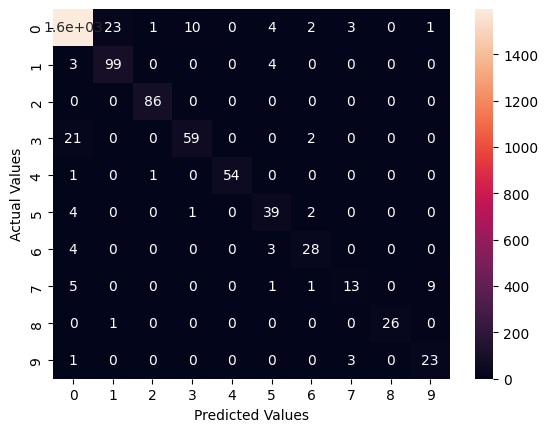

In [63]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

Se evidencia que hay una gran cantidad de datos para aquellos pacientes sanos, esto puede alterar a la precisión del modelo pues puede confundir varios de los pacientes realmente enfermos con pacientes sanos. Por ello, se realizazó el procedimiento de balanceo de datos.

## 5.2. Modelo con data balanceada

In [64]:
preds = best_model2.predict(X1_test)
acc = accuracy_score(y1_test, preds)
pre_macro = precision_score(y1_test, preds, average="macro")
pre_micro = precision_score(y1_test, preds, average="micro")
recall_macro = recall_score(y1_test, preds, average="macro")
recall_micro = recall_score(y1_test, preds, average="micro")
f1_macro = f1_score(y1_test, preds, average="macro")
f1_micro = f1_score(y1_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 93.51%
Macro-averaged Precision: 91.44%
Macro-averaged Recall: 92.11%
Macro-averaged F1 Score: 91.62%


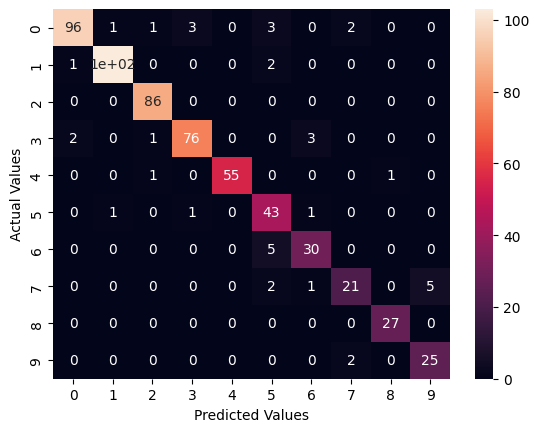

In [65]:
cm = confusion_matrix(y1_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

Vemos que, a pesar que el accuracy bajó, el modelo ahora cuenta con mejores valores de precision, recall y F1 score gracias al balanceo de los datos, y vemos que ahora el modelo no confundo a tantos pacientes enfermos con pacientes sanos.

# 6. Serializar ambos modelos

In [66]:
model1 = best_model1.best_estimator_
model1.fit(X_train, y_train)
print(accuracy_score(y_test, model1.predict(X_test)))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.9479606188466948


In [67]:
model2 = best_model2.best_estimator_
model2.fit(X1_train, y1_train)
print(accuracy_score(y1_test, model2.predict(X1_test)))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.9351081530782029


Guardamos los mejores modelos ajustados

In [68]:
file_model1 = "model1.pkl"
file_model2 = "model2.pkl"
with open(file_model1, "wb") as file:
    pickle.dump(model1, file)
with open(file_model2, "wb") as file:
    pickle.dump(model2, file)